In this task, we will look at how data dimensionality reduction and clustering methods work. At the same time, we'll practice solving classification task again.

We will work with the [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) dataset. The data comes from accelerometers and gyros of Samsung Galaxy S3 mobile phones ( you can find more info about the features using the link above), the type of activity of a person with a phone in his/her pocket is also known – whether he/she walked, stood, lay, sat or walked up or down the stairs.

First, we pretend that the type of activity is unknown to us, and we will try to cluster people purely on the basis of available features. Then we solve the problem of determining the type of physical activity as a classification problem.


In [1]:
import os
from zipfile import ZipFile
from pathlib import Path
import requests

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams["figure.figsize"] = (12, 9)
plt.rcParams["font.family"] = "DejaVu Sans"

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [2]:
def load_har_dataset(url, extract_path: Path, filename: str, overwrite=False):
    # check if existed already
    filepath = extract_path / filename
    if filepath.exists() and not overwrite:
        print("The dataset is already in place.")
        return

    print("Downloading the dataset from:  ", url)
    response = requests.get(url)

    with open(filepath, 'wb') as f:
        f.write(response.content)

    with ZipFile(filepath, 'r') as zipObj:
        # Extract all the contents of zip file in current directory
        zipObj.extractall(extract_path)

In [3]:
FILE_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"
FILE_NAME = "UCI HAR Dataset.zip"
#DATA_PATH = Path("../../../data/large_files")
DATA_PATH = Path("")

load_har_dataset(url=FILE_URL, extract_path=DATA_PATH, filename=FILE_NAME)

PATH_TO_SAMSUNG_DATA = DATA_PATH / FILE_NAME.strip('.zip')

The dataset is already in place.


In [4]:
X_train = np.loadtxt(PATH_TO_SAMSUNG_DATA / "train" / "X_train.txt")
y_train = np.loadtxt(PATH_TO_SAMSUNG_DATA / "train" / "y_train.txt").astype(int)

X_test = np.loadtxt(PATH_TO_SAMSUNG_DATA / "test" / "X_test.txt")
y_test = np.loadtxt(PATH_TO_SAMSUNG_DATA / "test" / "y_test.txt").astype(int)

In [5]:
# Checking dimensions
assert X_train.shape == (7352, 561) and y_train.shape == (7352,)
assert X_test.shape == (2947, 561) and y_test.shape == (2947,)

For clustering, we do not need a target vector, so we'll work with the combination of training and test samples. Merge `X_train` with `X_test`, and `y_train` with `y_test`.

In [7]:
x = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test]);

Define the number of unique values of the labels of the target class.

In [8]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [9]:
n_classes = np.unique(y).size
print(n_classes)

6


Scale the sample using `StandardScaler` with default parameters.

In [10]:
print(x)

[[ 0.28858451 -0.02029417 -0.13290514 ... -0.84124676  0.17994061
  -0.05862692]
 [ 0.27841883 -0.01641057 -0.12352019 ... -0.8447876   0.18028889
  -0.05431672]
 [ 0.27965306 -0.01946716 -0.11346169 ... -0.84893347  0.18063731
  -0.04911782]
 ...
 [ 0.34996609  0.03007744 -0.11578796 ... -0.65535684  0.27447878
   0.18118355]
 [ 0.23759383  0.01846687 -0.09649893 ... -0.65971859  0.26478161
   0.18756291]
 [ 0.15362719 -0.01843651 -0.13701846 ... -0.66008023  0.26393619
   0.1881034 ]]


In [11]:
scaler = StandardScaler()
scaled_x = scaler.fit_transform(x)
print(scaled_x)

[[ 2.10533854e-01 -6.87026385e-02 -4.52194533e-01 ... -6.74432366e-01
   3.82007658e-01 -1.61505480e-02]
 [ 6.02084832e-02  3.59023537e-02 -2.75221885e-01 ... -6.81359801e-01
   3.83147865e-01 -1.20627169e-04]
 [ 7.84597052e-02 -4.64269585e-02 -8.55480582e-02 ... -6.89470939e-01
   3.84288531e-01  1.92144041e-02]
 ...
 [ 1.11821625e+00  1.28805864e+00 -1.29414692e-01 ... -3.10750224e-01
   6.91509049e-01  8.75719123e-01]
 [-5.43492722e-01  9.75327452e-01  2.34319837e-01 ... -3.19283719e-01
   6.59762215e-01  8.99444350e-01]
 [-1.78515253e+00 -1.86663622e-02 -5.29759691e-01 ... -3.19991245e-01
   6.56994458e-01  9.01454465e-01]]


Reduce the number of dimensions using PCA, leaving as many components as necessary to explain at least 90% of the variance of the original (scaled) data. Use the scaled dataset and fix `random_state` (RANDOM_STATE constant).

In [12]:
def calc_variance(pca, n_components):

    sum_variance = 0
    for i, component in enumerate(pca.components_):
        sum_variance += round(100 * pca.explained_variance_ratio_[i], 2)

    print(f'Number of components = {n_components}; sum_variance = {sum_variance}')

    return sum_variance

In [13]:
n_components = 1
pca = PCA(n_components)
x_pca_reduced = pca.fit_transform(scaled_x)
sum_variance = calc_variance(pca, n_components)

Number of components = 1; sum_variance = 50.74


In [14]:
components_increment = 10

while sum_variance <= 90:
    n_components += components_increment
    pca = PCA(n_components)
    x_pca_reduced = pca.fit_transform(scaled_x)

    sum_variance = calc_variance(pca, n_components)

    if sum_variance <= 70:
        components_increment = 5

    if sum_variance >= 87.5:
        components_increment = 1

    if sum_variance >= 90:
        break

Number of components = 11; sum_variance = 71.07
Number of components = 21; sum_variance = 77.38
Number of components = 31; sum_variance = 81.66
Number of components = 41; sum_variance = 84.86999999999999
Number of components = 51; sum_variance = 87.35
Number of components = 61; sum_variance = 89.26999999999998
Number of components = 62; sum_variance = 89.43999999999998
Number of components = 63; sum_variance = 89.66000000000001
Number of components = 64; sum_variance = 89.83000000000001
Number of components = 65; sum_variance = 90.00999999999999


**Question 1:** <br>
What is the minimum number of principal components required to cover the 90% of the variance of the original (scaled) data?

In [48]:
#Number of components = 66; sum_variance = 90.19000000000001

**Question 2:**<br>
What percentage of the variance is covered by the first principal component? Round to the nearest percent.

In [16]:
#Number of components = 1; sum_variance = 50.74

Visualize data in projection on the first two principal components.

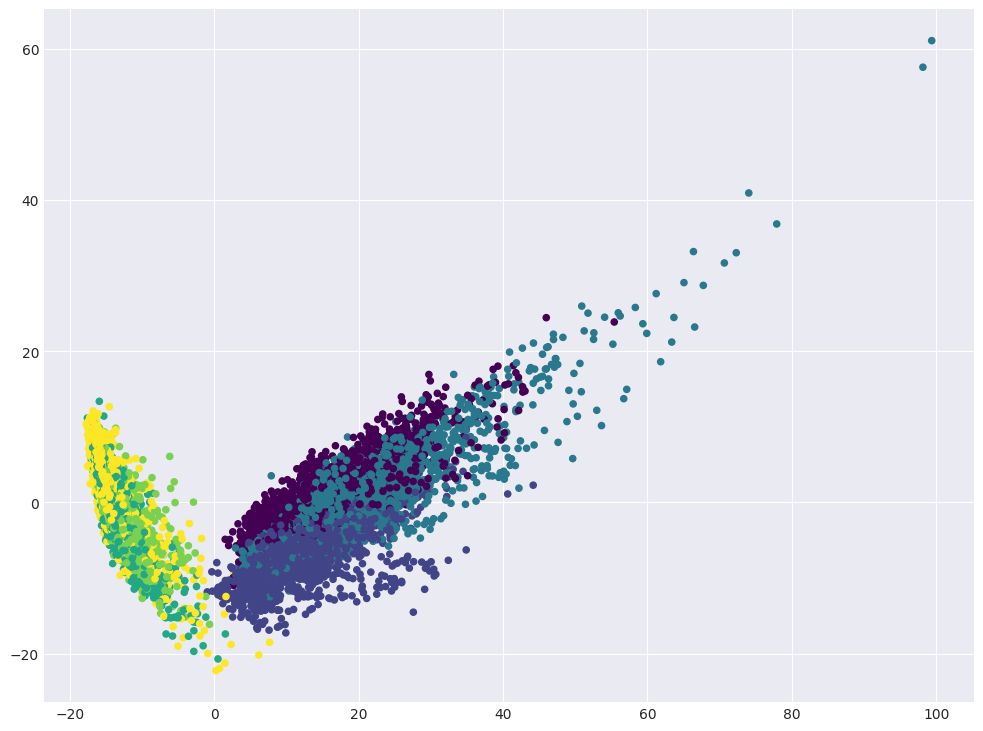

In [17]:
plt.scatter(x_pca_reduced[:, 0], x_pca_reduced[:, 1], c=y, s=20, cmap='viridis');

**Question 3:**<br>
If everything worked out correctly, you will see a number of clusters, almost perfectly separated from each other. What types of activity are included in these clusters? <br>

In [18]:
# 2 clusters: (walking, walking upstairs, walking downstairs ) and (sitting, standing, laying)

Perform clustering with the `KMeans` method, training the model on data with reduced dimensionality (by PCA). In this case, we will give a clue to look for exactly 6 clusters, but in general case we will not know how many clusters we should be looking for.

Options:

- `n_clusters` = n_classes (number of unique labels of the target class)
- `n_init` = 100
- `random_state` = RANDOM_STATE (for reproducibility of the result)

Other parameters should have default values.

In [19]:
kmeans = KMeans(n_clusters=n_classes, random_state=1337, n_init=100)
kmeans.fit(x_pca_reduced)

KMeans(n_clusters=6, n_init=100, random_state=1337)

Visualize data in projection on the first two principal components. Color the dots according to the clusters obtained.

In [20]:
cluster_labels = kmeans.labels_

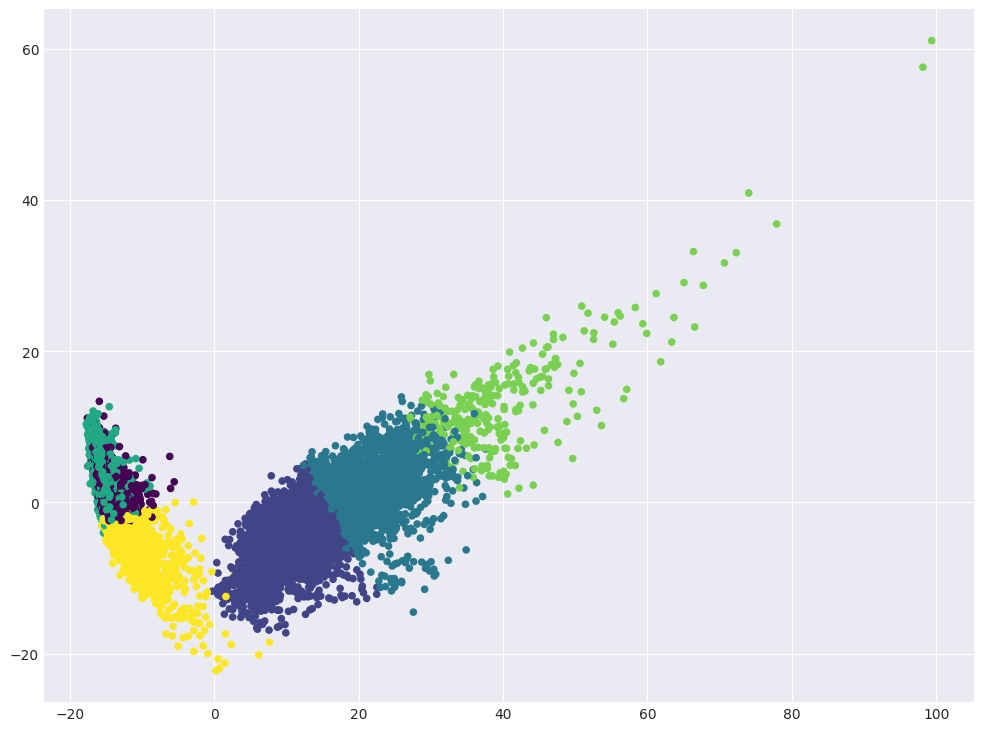

In [21]:
plt.scatter(x_pca_reduced[:, 0], x_pca_reduced[:, 1], c=cluster_labels, s=20, cmap='viridis');

In [22]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['walking', 'going up the stairs',
            'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['all']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,all
walking,0,901,743,0,78,0,1722
going up the stairs,0,1239,298,0,5,2,1544
going down the stairs,0,319,891,0,196,0,1406
sitting,1234,1,0,91,0,451,1777
standing,1340,0,0,0,0,566,1906
laying,53,5,0,1556,0,330,1944
all,2627,2465,1932,1647,279,1349,10299


We see that for each class (i.e., each activity) there are several clusters. Let's look at the maximum percentage of objects in a class that are assigned to a single cluster. This will be a simple metric that characterizes how easily the class is separated from others when clustering.

Example: if for class "walking downstairs" (with 1406 instances belonging to it), the distribution of clusters is:
 - cluster 1 - 900
 - cluster 3 - 500
 - cluster 6 - 6,

then such a share will be 900/1406 $ \approx $ 0.64.

**Question 4:** <br>
Which activity is separated from the rest better than others based on the simple metric described above? <br>

In [23]:
all_lables = tab['all']
cluster_lables = tab.drop('all', axis=1)

In [24]:
max_cluster_lables = cluster_lables.max(axis=1)
max_cluster_lables.head()

walking                   901
going up the stairs      1239
going down the stairs     891
sitting                  1234
standing                 1340
dtype: int64

In [25]:
accuracy = max_cluster_lables.div(all_lables)
accuracy.head()

walking                  0.523229
going up the stairs      0.802461
going down the stairs    0.633713
sitting                  0.694429
standing                 0.703043
dtype: float64

In [26]:
accuracy = accuracy.drop('all')

In [27]:
accuracy.sort_values()

walking                  0.523229
going down the stairs    0.633713
sitting                  0.694429
standing                 0.703043
laying                   0.800412
going up the stairs      0.802461
dtype: float64

It can be seen that kMeans does not distinguish activities very well. Use the elbow method to select the optimal number of clusters. Parameters of the algorithm and the data we use are the same as before, we change only `n_clusters`.


In [28]:
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, random_state=1337, n_init=100)
    kmeans.fit(x_pca_reduced)
    inertia.append(np.sqrt(kmeans.inertia_))

C:\Users\gusak\AppData\Local\Temp\ipykernel_15456\464624055.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(1, n_classes + 1)):


  0%|          | 0/6 [00:00<?, ?it/s]

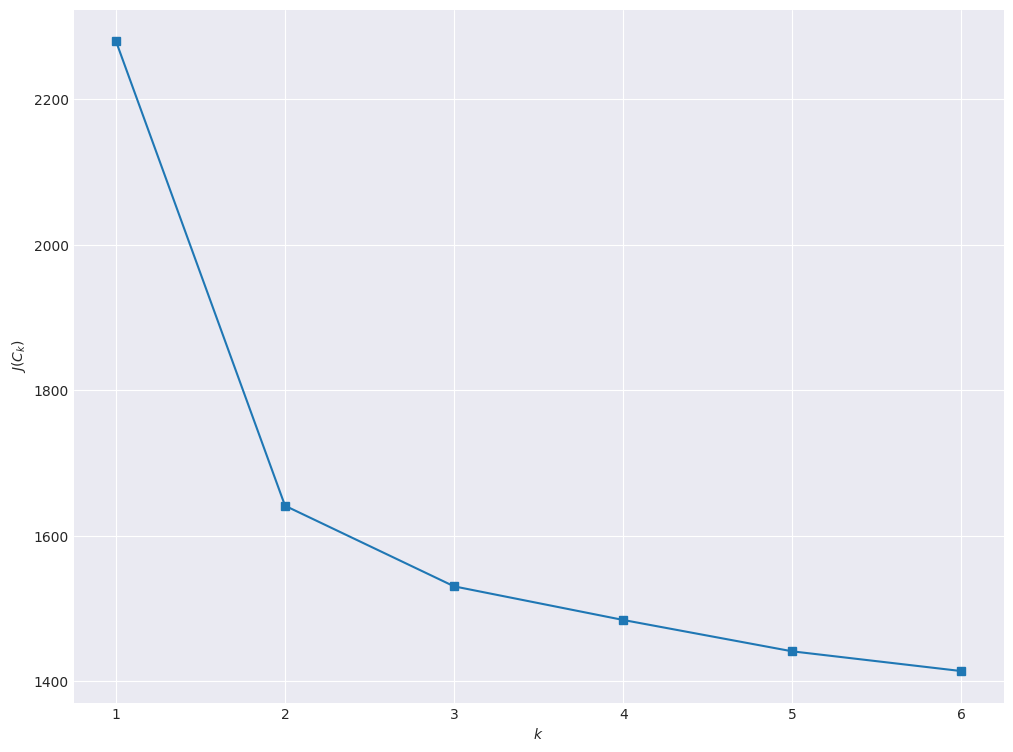

In [29]:
plt.plot(range(1, n_classes + 1), inertia, marker="s")
plt.xlabel("$k$")
plt.ylabel("$J(C_k)$");

**Question 5:** <br>
How many clusters can we choose according to the elbow method? <br>

Answer: 2

Let’s try another clustering algorithm, described in the article – agglomerative clustering.

In [31]:
ag = AgglomerativeClustering(n_clusters=n_classes, linkage='ward').fit(x_pca_reduced)

Calculate the Adjusted Rand Index (`sklearn.metrics`) for the resulting clustering and for ` KMeans` with the parameters from the 4th question.

In [32]:
print("KMeans: ARI =", metrics.adjusted_rand_score(y, cluster_labels))
print("Agglomerative CLustering: ARI =", metrics.adjusted_rand_score(y, ag.labels_))

KMeans: ARI = 0.4190984387263994
Agglomerative CLustering: ARI = 0.3627281017491839


In [33]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [34]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {"C": [0.001, 0.01, 0.1, 1, 10]}

In [35]:
%%time
clf = GridSearchCV(svc, svc_params, n_jobs=-1, cv=3)
best_svc = clf.fit(X_train_scaled, y_train)

CPU times: total: 5.5 s
Wall time: 39 s


C:\Users\gusak\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [36]:
best_svc.best_params_, best_svc.best_score_

({'C': 0.1}, 0.9382506099134881)

**Question 7**<br>
Which value of the hyperparameter `C` was chosen the best on the basis of cross-validation? <br>


In [38]:
y_predicted = best_svc.predict(X_test_scaled)

In [39]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['walking', 'climbing up the stairs',
             'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab.columns = ['walking', 'climbing up the stairs',
             'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab

,walking,climbing up the stairs,going down the stairs,sitting,standing,laying,all
walking,479,11,4,2,0,0,496
climbing up the stairs,4,465,1,1,0,0,471
going down the stairs,1,2,416,1,0,0,420
sitting,0,4,0,433,52,2,491
standing,0,0,0,16,516,0,532
laying,0,0,0,0,6,531,537
all,484,482,421,453,574,533,2947


**Question 8:** <br>
Which activity type is worst detected by SVM in terms of precision? Recall?<br>

Answer: precision – standing, recall – sitting

Finally, do the same thing as in Question 7, but add PCA.

- Use `X_train_scaled` and` X_test_scaled`
- Train the same PCA as before, on the scaled training set, apply scaling to the test set
- Choose the hyperparameter `C` via cross-validation on the training set with PCA-transformation. You will notice how much faster it works now.

In [45]:
n_components = 1
pca = PCA(n_components)
x_train_pca_reduced = pca.fit_transform(X_train_scaled)
sum_variance = calc_variance(pca, n_components)
components_increment = 10

while sum_variance <= 90:
    n_components += components_increment
    pca = PCA(n_components)
    x_train_pca_reduced = pca.fit_transform(X_train_scaled)

    sum_variance = calc_variance(pca, n_components)

    if sum_variance <= 70:
        components_increment = 5

    if sum_variance >= 87.5:
        components_increment = 1

    if sum_variance >= 90:
        break

Number of components = 1; sum_variance = 50.78
Number of components = 11; sum_variance = 71.68
Number of components = 21; sum_variance = 77.89
Number of components = 31; sum_variance = 82.17
Number of components = 41; sum_variance = 85.33
Number of components = 51; sum_variance = 87.78999999999999
Number of components = 52; sum_variance = 87.99999999999999
Number of components = 53; sum_variance = 88.20999999999998
Number of components = 54; sum_variance = 88.41999999999999
Number of components = 55; sum_variance = 88.61
Number of components = 56; sum_variance = 88.81
Number of components = 57; sum_variance = 88.92999999999999
Number of components = 58; sum_variance = 89.14000000000001
Number of components = 59; sum_variance = 89.30000000000001
Number of components = 60; sum_variance = 89.49000000000001
Number of components = 61; sum_variance = 89.68000000000002
Number of components = 62; sum_variance = 89.84000000000002
Number of components = 63; sum_variance = 90.05


In [46]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {"C": [0.001, 0.01, 0.1, 1, 10]}

In [47]:
%%time
clf = GridSearchCV(svc, svc_params, n_jobs=-1, cv=3)
best_svc = clf.fit(x_train_pca_reduced, y_train)
best_svc.best_params_, best_svc.best_score_

CPU times: total: 1.59 s
Wall time: 7.33 s


C:\Users\gusak\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


({'C': 1}, 0.9011179665664716)

**Question 9:** <br>
What is the difference between the best quality (accuracy) for cross-validation in the case of all 561 initial characteristics and in the second case, when the principal component method was applied? Round to the nearest percent. <br>

Answer: 4%